# Исследование гипотез для увеличения выручки

Есть данные крупного интернет-магазина о посетителях, заказах и гипотезах. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

План работы:
1) проведем предобработку данных;

2) приоритизируем гипотезы с применением фреймворков ICE и RICE;

3) проанализируем А/В-тест:
- рассмотрим графики кумулятивной выручки и кумулятивного среднего чека по группам, а так же изменения кумулятивного среднего чека группы В к группе А
- рассмотрим графики кумулятивного среднего количества заказов на посетителя по группам, а так же его изменения для группы В к группе А
- определим аномальных пользователей
- посчитаем статистическую значимость различий в среднем чеке заказа и среднем количестве заказов на посетителя до фильтрации и после

## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
from scipy.stats import binom, norm
from math import sqrt
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

In [3]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')

In [4]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [5]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


<div style="border: solid purple 2px; padding: 20px">
В таблице hypothesis 9 строк, таблица содержит информацию с кратким описанием гипотез, охватом пользователей по 10-балльной шкале, влиянием на пользователей по 10-балльной шкале, уверенностью в гипотезе по 10-балльной шкале и затратами ресурсов на проверку гипотезы по 10-балльной шкале. Пропусков нет, изменять тип даннх не нужно, приведем назвния столбцов к нижнему регистру.

In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


<div style="border: solid purple 2px; padding: 20px">В таблице orders 1197 строк, таблица содержит информацию о идентификаторе заказа, идентификаторе пользователя, совершившего заказ, дате заказа, выручке заказа и группе А/В-теста, в которую попал заказ. Пропусков нет, стоит изменить тип данных в колонке date и привести названия столбцов к "змеиному" регистру.

In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


<div style="border: solid purple 2px; padding: 20px">В таблице visitors 62 строки, таблица содержит информацию о дате, группе А/В-теста и количестве пользователей в указанную дату в указанной группе А/В-теста. Пропусков нет, стоит изменить тип данных колонки с датой.

## Предобработка данных

###  Переименование колонок и изменение типа данных

In [11]:
hypothesis.columns=[col.lower() for col in hypothesis.columns] 
# функция приводит название колонок к нижнему регистру

In [12]:
hypothesis.columns # проверка

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [13]:
orders.columns=['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [14]:
orders.columns # проверка

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [15]:
orders['date'] = pd.to_datetime(orders['date'])

In [16]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [17]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [18]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


<div style="border: solid purple 2px; padding: 20px">Исправить стиль в заголовках столбцов стоит для единообразия и удобства последуйщей работы с ними, а тип данных нужно изменить для корректности работы с данными даты.

### Обработка дубликатов

In [19]:
hypothesis.duplicated().sum()

0

In [20]:
orders.duplicated().sum()

0

In [21]:
visitors.duplicated().sum()

0

<div style="border: solid purple 2px; padding: 20px">Дубликатов в таблице нет.

### Проверка правильности разделения по группам А/В

In [22]:
orders.groupby('group')['visitor_id'].nunique()

group
A    503
B    586
Name: visitor_id, dtype: int64

In [23]:
visitors_A = orders.query('group == "A"')

In [24]:
visitors_B = orders.query('group == "B"')

In [25]:
visitors_A_user_id_list = list(visitors_A["visitor_id"])

In [26]:
visitors_B_user_id_list = list(visitors_B["visitor_id"])

In [27]:
visitors_both = orders.\
query('visitor_id in @visitors_A_user_id_list and visitor_id in @visitors_B_user_id_list')

In [28]:
visitors_both['visitor_id'].nunique() # количество пользователей, попавших и в группу А, и в группу В

58

In [29]:
visitors_both_user_id_list = list(visitors_both["visitor_id"])

In [30]:
orders = orders.query('visitor_id not in @visitors_both_user_id_list')

<div style="border: solid purple 2px; padding: 20px">Удалили тех пользователей в таблице orders, которых отнесли к двум группам одновременно, однако из-за агрегированных данных в таблице visitors этого сделать не получится. Нужно обратить внимание на эту ошибку при проведении следующих А/В-тестов.

## Приоритизация гипотез

### Фреймворк ICE для приоритизации гипотез

In [31]:
pd.options.display.max_colwidth = 120

In [32]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [33]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

In [34]:
hypothesis['ICE'] = round(hypothesis['ICE'], 3)

In [35]:
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000


<div style="border: solid purple 2px; padding: 20px">
Наиболее перспективные гипотезы по ICE:
    
- запустить акцию, дающую скидку на товар в день рождения;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### Фреймворк RICE для приоритизации гипотез

In [36]:
hypothesis['RICE'] = hypothesis['impact']*hypothesis['confidence']*hypothesis['reach']/hypothesis['efforts']

In [37]:
hypothesis['RICE'] = round(hypothesis['RICE'], 3)

In [38]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.0


<div style="border: solid purple 2px; padding: 20px"> 
Наиболее перспективные гипотезы по RICE:
    
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

<div style="border: solid purple 2px; padding: 20px"> 
Гипотезы:
    
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
    
являются приоритетными для двух фреймфорков ICE и RICE, гипотеза о запуске акции, дающую скидку на товар в день рождения сместилась ниже, а гипотеза о добавлении блоков рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа наоброт поднялась за счет бОльшего охвата. 
    
Первостепенно стоит обратить внимание на гипотезы:

- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    
они имеют один из самых высоких параметров impact и reach при среднем параметре efforts.


## Анализ A/B-теста

### Первичный анализ данных

В предобработке были удалены пользователи, которые относились к двум группам одновременно. Теперь посмотрим, за какой период собирались данные для исследования и сколько пользователей приняло участие.

In [39]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


In [40]:
orders['visitor_id'].nunique()

973

In [41]:
visitors['date'].unique()

array(['2019-08-01T00:00:00.000000000', '2019-08-02T00:00:00.000000000',
       '2019-08-03T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000', '2019-08-06T00:00:00.000000000',
       '2019-08-07T00:00:00.000000000', '2019-08-08T00:00:00.000000000',
       '2019-08-09T00:00:00.000000000', '2019-08-10T00:00:00.000000000',
       '2019-08-11T00:00:00.000000000', '2019-08-12T00:00:00.000000000',
       '2019-08-13T00:00:00.000000000', '2019-08-14T00:00:00.000000000',
       '2019-08-15T00:00:00.000000000', '2019-08-16T00:00:00.000000000',
       '2019-08-17T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
       '2019-08-19T00:00:00.000000000', '2019-08-20T00:00:00.000000000',
       '2019-08-21T00:00:00.000000000', '2019-08-22T00:00:00.000000000',
       '2019-08-23T00:00:00.000000000', '2019-08-24T00:00:00.000000000',
       '2019-08-25T00:00:00.000000000', '2019-08-26T00:00:00.000000000',
       '2019-08-27T00:00:00.000000000', '2019-08-28

<div style="border: solid purple 2px; padding: 20px">А/В-тест проводился с 1 августа 2019 года по 31 августа 2019 года, т.е. один месяц. В нем приняло участие 973 человека. Нет данных о целях А/В-теста, каких изменеий хотят достигнуть и в каких показателях, поэтому нет возможности оценить, достаточно ли долго он проводился и на достаточном количестве пользователей. 

### График кумулятивной выручки по группам

In [42]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [43]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [44]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [45]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [46]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [47]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [48]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


In [49]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [50]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

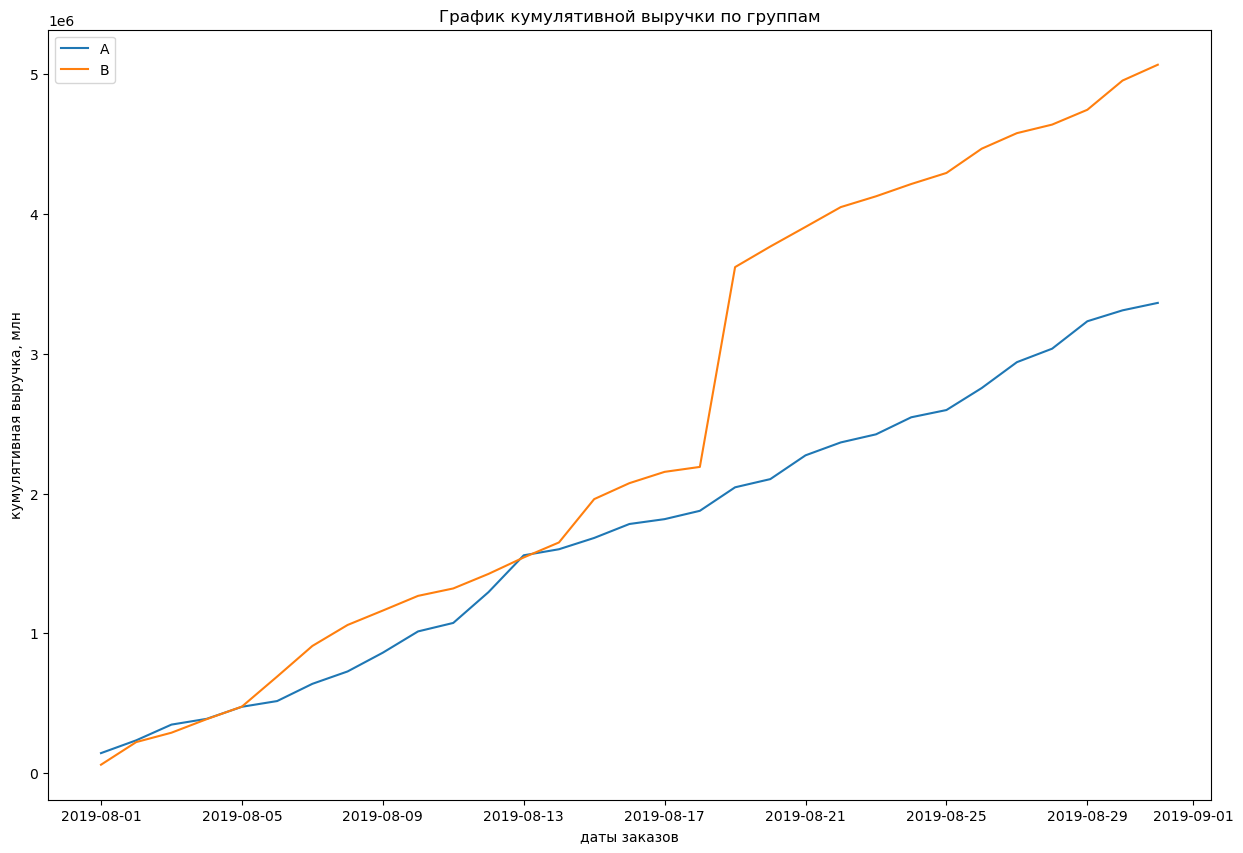

In [51]:
plt.subplots(figsize=(15,10))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.xlabel('даты заказов')
plt.ylabel('кумулятивная выручка, млн')
plt.title('График кумулятивной выручки по группам');

<div style="border: solid purple 2px; padding: 20px">Видно, что для группы В кумулятивная выручка выросла резко в один из дней и это сказалось на всем графике. Однако до резкого роста так же видно, что выручка группы В чуть больше выручки группы А. Вероятно, дело в одном или нескольких аномально дорогих заказов, либо же аномально большого количества заказов.

### График кумулятивного среднего чека по группам

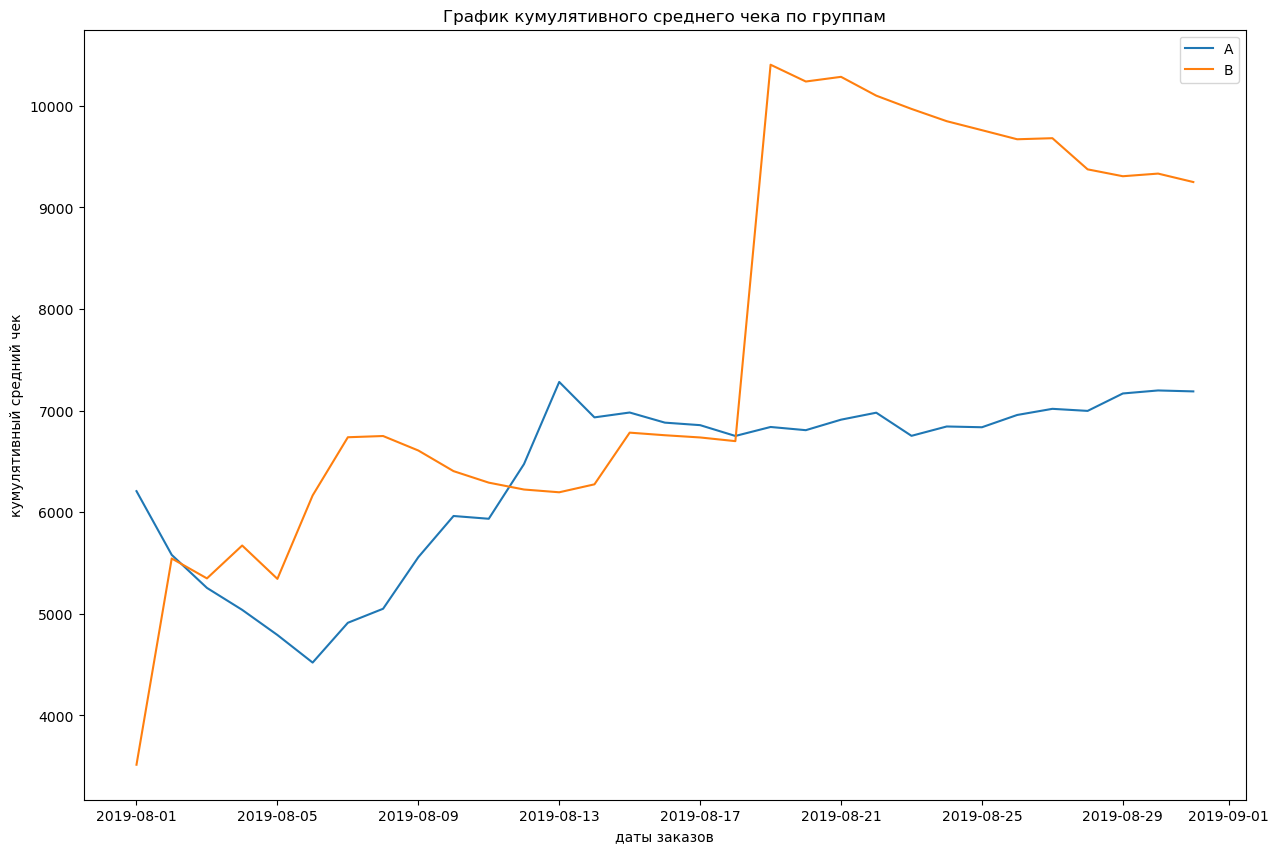

In [52]:
plt.subplots(figsize=(15,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xlabel('даты заказов')
plt.ylabel('кумулятивный средний чек')
plt.title('График кумулятивного среднего чека по группам');

<div style="border: solid purple 2px; padding: 20px">Видно, что в тот же день, где был пик кумулятивной выручки по группам, есть пик и в среднем чеке для группы В. Скорее всего в этот день была сделана одна или несколько дорогостоящих покупок пользователями из группы В. Даже без учета пика сложно выявить лидера графика по среднему чеку.

Выясним, что это был за день и за заказ/заказы

In [53]:
cumulativeRevenueB

,date,revenue,orders
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89
11,2019-08-06,690490,112
13,2019-08-07,909654,135
15,2019-08-08,1059795,157
17,2019-08-09,1162961,176
19,2019-08-10,1268123,198


In [54]:
orders.query('date == "2019-08-19"')

,transaction_id,visitor_id,date,revenue,group
308,2669609377,3511496907,2019-08-19,1900,A
309,2727336513,2629148010,2019-08-19,2690,A
315,1939633950,157579733,2019-08-19,2330,B
316,4226817726,1349865791,2019-08-19,2490,A
317,486115048,2358787737,2019-08-19,2526,A
318,3412626998,3282099314,2019-08-19,11985,A
319,2414788465,2247745159,2019-08-19,1435,B
320,1652782757,2763027084,2019-08-19,1460,B
321,1775445570,3118528100,2019-08-19,1090,A
322,3154167297,2091902649,2019-08-19,250,B


In [55]:
orders.query('visitor_id == 1920142716')

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Был сделан заказ на 19 августа 2019 год на сумму 1294500 пользователем с visitor_id 1920142716. В дальнейшем этот заказак как аномальный будет исключен при подсчете статистическиз значимостей.

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [56]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

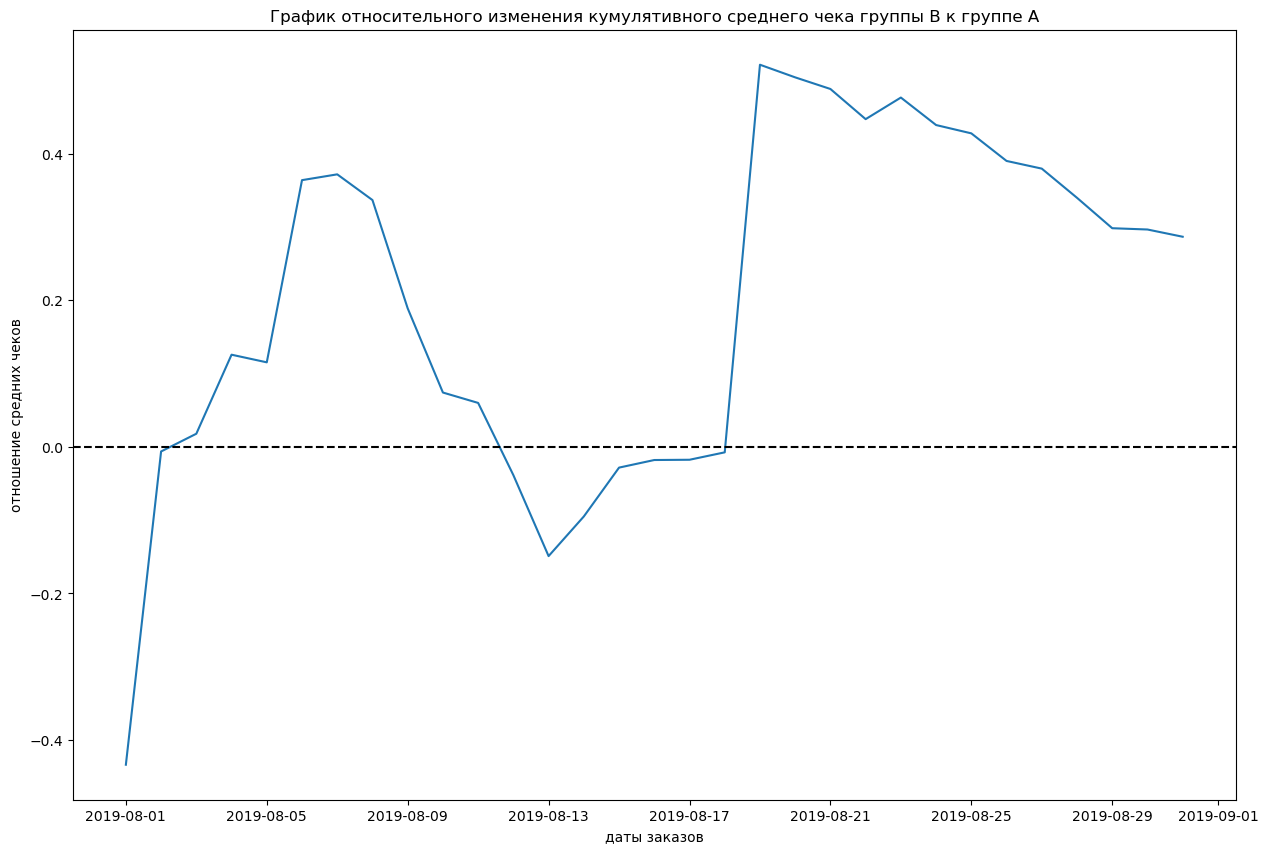

In [57]:
plt.subplots(figsize=(15,10))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('даты заказов')
plt.ylabel('отношение средних чеков')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A');

<div style="border: solid purple 2px; padding: 20px">По этому же графику видно, что относительное изменение в начале эксперемента больше для группы В, однако даже после пика 19 августа изменение падает, и, возможно, без этого заказа оно было бы ниже нуля, что может говорить о том, что группа В не лучше чем группа А.

### График кумулятивного среднего количества заказов на посетителя по группам

In [58]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [59]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [60]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

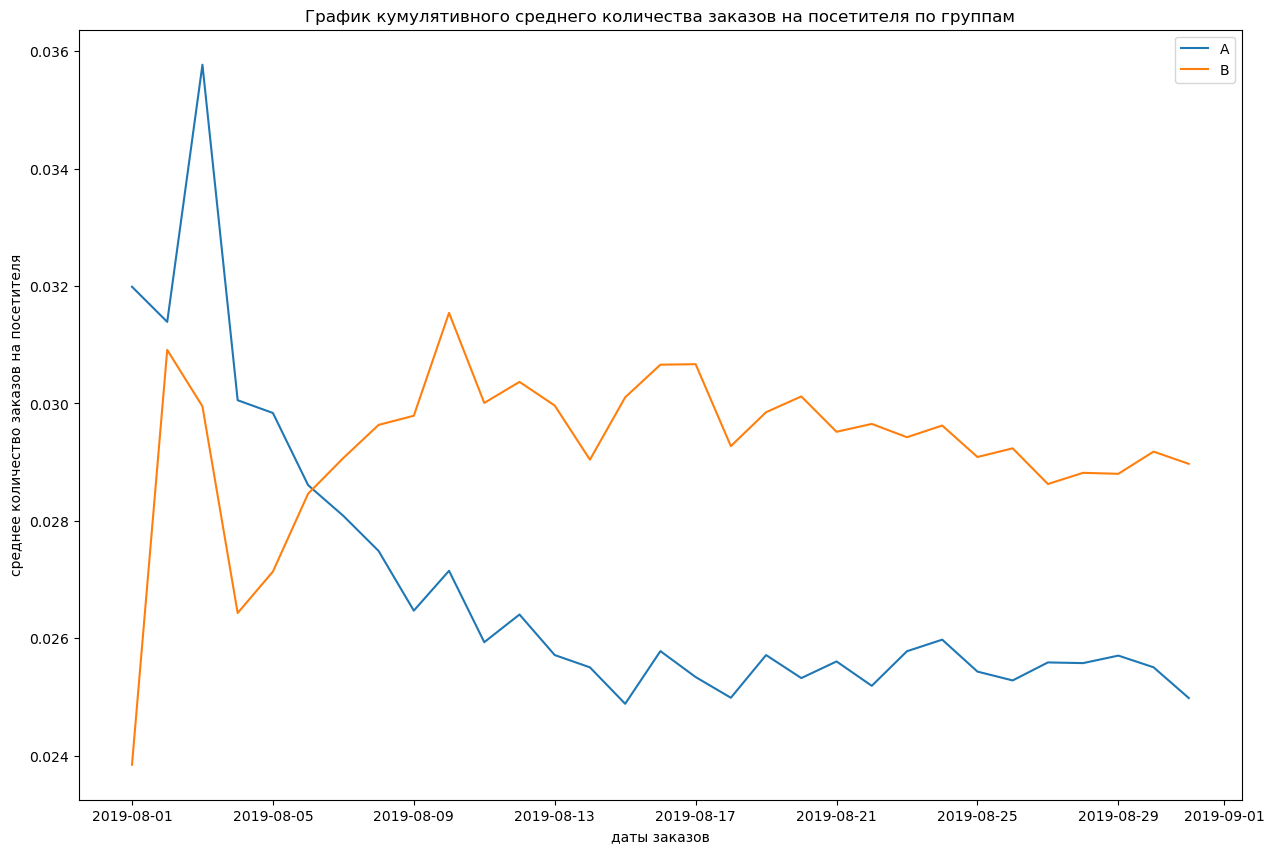

In [61]:
plt.subplots(figsize=(15,10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('даты заказов')
plt.ylabel('среднее количество заказов на посетителя')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам');

<div style="border: solid purple 2px; padding: 20px">На графике конверсии посетителей в заказы видно что в среднем количество заказов на посетителя для группы В выше, чем для группы А, что может говорить о том, что посетители из группы В покупают чаще. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

In [62]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

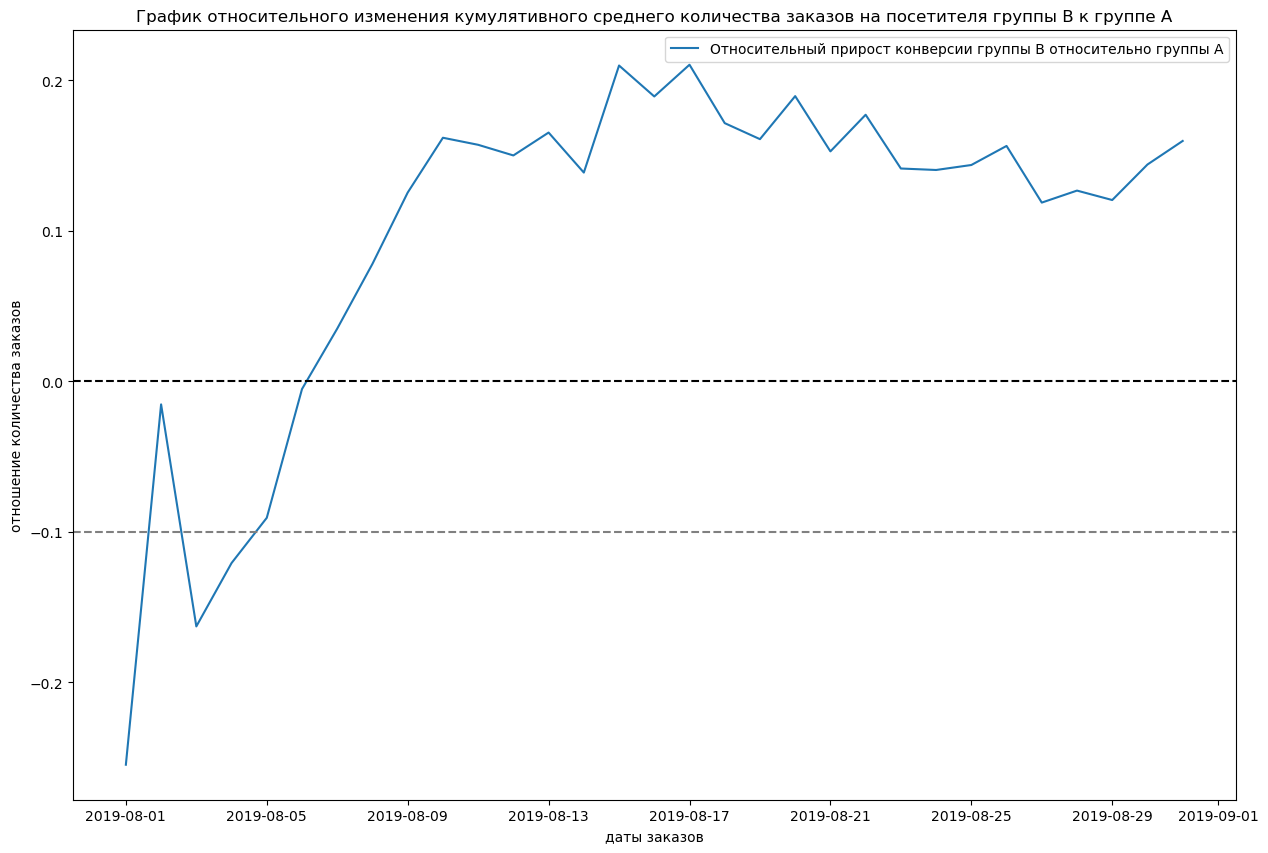

In [63]:
plt.subplots(figsize=(15,10))
plt.plot(mergedCumulativeConversions['date'], \
mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xlabel('даты заказов')
plt.ylabel('отношение количества заказов')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A');

<div style="border: solid purple 2px; padding: 20px"> На этом графике видно, что пользователи из группы В лучше конвертируются в заказы, чем пользователи из группы А.

### График количества заказов по пользователям

In [64]:
# количество заказов каждого пользователя
ordersByUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

In [65]:
ordersByUsers.columns = ['visitor_id', 'orders']

In [66]:
x_values = pd.Series(range(0,len(ordersByUsers)))

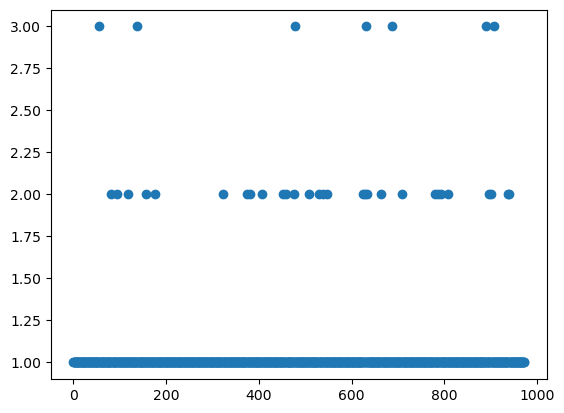

In [67]:
plt.scatter(x_values, ordersByUsers['orders']);

<div style="border: solid purple 2px; padding: 20px">Практически все заказывают не больше чем один раз за все время исследования (месяц). Хорошо ли это? Смотря что мы продаем. Если, к примеру, это какие-нибудь билеты в театр, то это вполне приемлемо. Если же это что-то более бытовое, то это скорее проблема, которую нужно изучать.

### Граница количества заказов на пользователя для определения аномальных пользователей

In [68]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

<div style="border: solid purple 2px; padding: 20px">Выберем границу от 1 заказа, ведь не более 5% пользователей сделало больше 1 заказа. 

### График стоимостей заказов

In [69]:
x_values = pd.Series(range(0,len(orders['revenue'])))

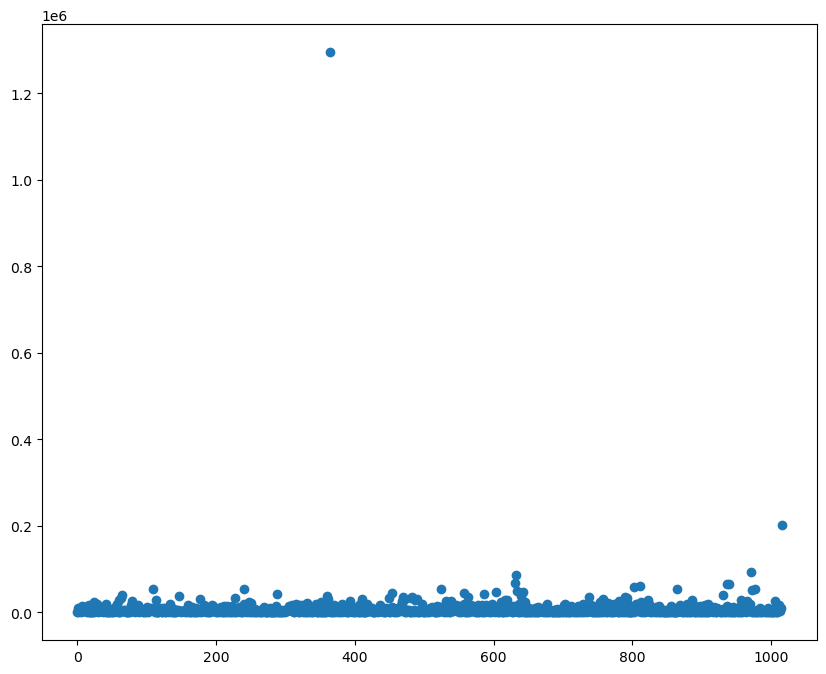

In [70]:
plt.subplots(figsize=(10,8))
plt.scatter(x_values, orders['revenue']);

Из-за пика на сумму 1294500 весь график прижался к нулю. 

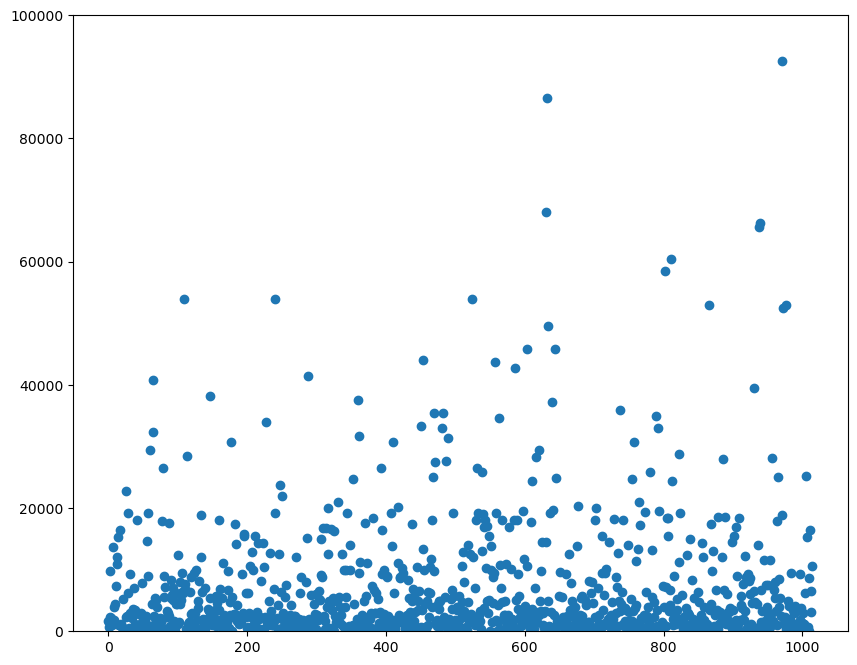

In [71]:
plt.subplots(figsize=(10,8))
plt.ylim([0, 100000])
plt.scatter(x_values, orders['revenue']);

<div style="border: solid purple 2px; padding: 20px">В целом большинство заказов по стоимости не превышают 25000, даже можно предположить, что не превышают 10000.

### Граница стоимости заказов для определения аномальных заказов

In [72]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

<div style="border: solid purple 2px; padding: 20px">Аномальными заказами будем счиать те, чья стоимость больше 30000.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [73]:
# количество пользователей группы А каждый день
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [74]:
# количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]\
                                            .agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [75]:
# количество пользователей группы В каждый день
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [76]:
# количество пользователей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
                                            .agg({'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [77]:
# количество заказов и выручки с них для пользователей в группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [78]:
# суммарное число заказов и выручки выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
                                        .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1)\
                                 .sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA','revenueCummulativeA']

In [79]:
# количество заказов и выручки с них для пользователей в группе B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [80]:
# суммарное число заказов и выручки выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
                                        .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1)\
                                 .sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB','revenueCummulativeB']

In [81]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


In [82]:
# количество заказов для каждого пользователя, который сделал хотя бы один заказ, из группы А
ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})

ordersByUsersA.columns = ['visitor_id', 'orders']

In [83]:
# количество заказов для каждого пользователя, который сделал хотя бы один заказ, из группы В
ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})

ordersByUsersB.columns = ['visitor_id', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах

In [84]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [85]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Cформулируем гипотезы

0. Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет.
1. Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть.

In [86]:
st.mannwhitneyu(sampleA, sampleB)[1]

0.011018084110014696

<div style="border: solid purple 2px; padding: 20px">p-value = 0.0110, меньше чем 0.05. Значит, <u>нулевую гипотеза</u> о том, что различий в среднем количестве заказов на посетителя между группами нет <b>отвергаем</b>, а  <u>альтернативную гипотезу</u> о том, что различия в среднем количестве заказов на посетителя между группами есть <b>принимаем верной</b>.

In [87]:
sampleB.mean() / sampleA.mean() - 1

0.1597977924896936

<div style="border: solid purple 2px; padding: 20px">Выигрыш группы В в среднем количестве заказов равен практически 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Cформулируем гипотезы

0. Нулевая гипотеза: различий в среднем чеке заказа между группами нет.
1. Альтернативная гипотеза: различия в среднем чеке заказа между группами есть.

In [88]:
st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

0.8294908998149533

<div style="border: solid purple 2px; padding: 20px">p-value = 0.83, больше 0.05. <u>Нулевая гипотеза</u> о том, что различий в среднем чеке заказа между группами нет <b>не отвергается</b>.

In [89]:
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1

0.28660287636871096

<div style="border: solid purple 2px; padding: 20px"> Наблюдаемая, но не статистически значимая, разница между группами в среднем чеке заказа составляет 28,66%

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [90]:
max_orders = np.percentile(ordersByUsers['orders'], [95])[0]

In [91]:
max_revenue = np.percentile(orders['revenue'], [95])[0]

In [92]:
f'Примем за аномальных пользователей тех, кто совершил от {max_orders} заказа или совершил заказ дороже {max_revenue}'

'Примем за аномальных пользователей тех, кто совершил от 1.0 заказа или совершил заказ дороже 26785.0'

In [93]:
f'Сделаем срезы пользователей с числом заказов больше {max_orders} — usersWithManyOrders и пользователей, совершивших заказы дороже {max_revenue} — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers'

'Сделаем срезы пользователей с числом заказов больше 1.0 — usersWithManyOrders и пользователей, совершивших заказы дороже 26785.0 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers'

In [94]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [95])[0]]['visitor_id'],\
                                 ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [95])[0]]['visitor_id']],axis=0)

In [95]:
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95])[0]]['visitor_id']


In [96]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

In [97]:
abnormalUsers.shape[0]

86

77 аномальных пользователей

In [98]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [99]:
sampleBFiltered = pd.concat(
    [        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Cформулируем гипотезы

0. Нулевая гипотеза: различий в среднем количестве заказов на посетителя между группами нет.
1. Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть

In [100]:
st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

0.01593020716573973

<div style="border: solid purple 2px; padding: 20px">p-value = 0.0125, стал чуть больше, чем до фильтрации. Значит, <u>нулевую гипотеза</u> о том, что различий в среднем количестве заказов на посетителя между группами нет <b>отвергаем</b>, а  <u>альтернативную гипотезу</u> о том, что различия в среднем количестве заказов на посетителя между группами есть <b>принимаем верной</b>.

In [101]:
sampleBFiltered.mean()/sampleAFiltered.mean()-1

0.17392968945597698

<div style="border: solid purple 2px; padding: 20px">Выигрыш группы В в количестве заказов примерно такой же, как и был до фильтрации, 17.96%

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Cформулируем гипотезы

0. Нулевая гипотеза: различий в среднем чеке заказа между группами нет.
1. Альтернативная гипотеза: различия в среднем чеке заказа между группами есть.

In [102]:
st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]

0.7271286894009963

<div style="border: solid purple 2px; padding: 20px">p-value практически не изменился, <u>нулевая гипотеза</u> о том, что различий в среднем чеке заказа между группами нет <b>не отвергается</b>.

In [103]:
orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()\
        / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()\
        - 1

-0.03373405744316604

<div style="border: solid purple 2px; padding: 20px">Наблюдаемая, но не статистически значимая, разница в среднем чеке составила 1% в пользу группы А.

## Выводы

<div style="border: solid purple 2px; padding: 20px">
    
1. А/В-тест проводился с 1 августа 2019 года по 31 августа 2019 года, т.е. один месяц. В нем приняло участие 973 человека. Нужно обратить внимание на ошибку сбора данных при проведении следующих А/В-тестов.
    
   
2. Однозначно по графикам можно сказать только то, что посетители из группы В конвертируются в заказы лучшем, чем посетители из группы А. 
    
    
3. До фильтрации проверка гипотез показала:
    - Различия в среднем количестве заказов на посетителя между группами есть. Выигрыш группы В среднем количестве заказов равен практически 16%.
    - Нет оснований полагать, что есть различия в среднем чеке между группами. Наблюдаемая, но не статистически значимая, разница между группами в среднем чеке заказа составляет 28,66%.
    
   
4. После фильтрации проверка гипотез показала:
    - Различия в среднем количестве заказов на посетителя между группами есть. Выигрыш группы В в количестве заказов примерно такой же, как и был до фильтрации, 17,96%.
    - Нет оснований полагать, что есть различия в среднем чеке между группами. Наблюдаемая, но не статистически значимая, разница в среднем чеке составила 1% в пользу группы А.

    
5. Рекомендации:

    - Продолжать тест не имеет смысла, группа А не станет лучше в количестве заказов чем группа В. Для показателя среднего чека разницы между группами нет. Если целью А/В-тестирование было увеличение количество заказов, то можно зафиксировать победу группы В, если средний чек, то зафиксировать отсутсвие разницы между группами.
    - Обратить внимание на количество заказов, если это интернет-магазин с товарами, которые пользователи могут часто покупать.
    - Обратить внимание на ошибку в сборе данных для проведения А/В-тестирования, предварительно провести А/А-тест.